# Leukemia classification 
By Zoe Plumridge
Based on code generated by openAI

In [21]:
import os
import csv
import random
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models

from sklearn.metrics import roc_auc_score, accuracy_score

In [326]:
# -------------------------
# Config / paths
# -------------------------
DATA_ROOT = "./leukemia-classification/C-NMC_Leukemia"
TRAIN_ROOT = os.path.join(DATA_ROOT, "training_data")
VAL_ROOT = os.path.join(DATA_ROOT, "validation_data")   # unlabeled
TEST_ROOT = os.path.join(DATA_ROOT, "testing_data")     # unlabeled

OUTPUT_DIR = "./output_pytorch"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [266]:
IMG_SIZE = 100
BATCH_SIZE = 8
NUM_WORKERS = 4
SEED = 123
EPOCHS_HEAD = 3
EPOCHS_FINETUNE = 1
LR_HEAD = 1e-3
LR_FINETUNE = 1e-4
VAL_SPLIT = 0.10   # fraction of training used as labeled validation for monitoring

IMG_EXTS = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")

In [24]:
# reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


## Helpers to collect files

In [25]:
def collect_labeled_images(root):
    paths = []
    labels = []
    for dirpath, dirnames, filenames in os.walk(root):
        for fname in filenames:
            if not fname.lower().endswith(IMG_EXTS):
                continue
            full = os.path.join(dirpath, fname)
            parts = [p.lower() for p in full.split(os.sep)]
            if "all" in parts:
                label = 1
            elif "hem" in parts:
                label = 0
            else:
                continue
            paths.append(full)
            labels.append(label)
    # sort for determinism
    pairs = sorted(zip(paths, labels))
    if not pairs:
        return [], []
    paths, labels = zip(*pairs)
    return list(paths), list(labels)

In [26]:
def collect_unlabeled_images(root):
    paths = []
    for dirpath, dirnames, filenames in os.walk(root):
        for fname in filenames:
            if not fname.lower().endswith(IMG_EXTS):
                continue
            paths.append(os.path.join(dirpath, fname))
    paths = sorted(paths)
    return paths

In [27]:
train_paths, train_labels = collect_labeled_images(TRAIN_ROOT)
val_unlabeled_paths = collect_unlabeled_images(VAL_ROOT)
test_unlabeled_paths = collect_unlabeled_images(TEST_ROOT)

print(f"Found {len(train_paths)} labeled train images, {len(val_unlabeled_paths)} unlabeled val images, {len(test_unlabeled_paths)} unlabeled test images")
if len(train_paths) == 0:
    raise SystemExit("No training images found. Check TRAIN_ROOT path and folder names.")

Found 10662 labeled train images, 1868 unlabeled val images, 2586 unlabeled test images


## PyTorch Dataset classes

In [28]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

In [29]:
class LabeledImageDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

In [30]:
class UnlabeledImageDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, p

## Make datasets and dataloaders (with small labeled val split)

In [31]:
n_total = len(train_paths)
idxs = list(range(n_total))
random.shuffle(idxs)
n_val = max(1, int(n_total * VAL_SPLIT))
val_idxs = idxs[:n_val]
train_idxs = idxs[n_val:]

train_ds = LabeledImageDataset([train_paths[i] for i in train_idxs],
                               [train_labels[i] for i in train_idxs],
                               transform=train_transform)
val_ds_labeled = LabeledImageDataset([train_paths[i] for i in val_idxs],
                                     [train_labels[i] for i in val_idxs],
                                     transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds_labeled, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_unlabeled_loader = DataLoader(UnlabeledImageDataset(val_unlabeled_paths, transform=val_transform),
                                  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_unlabeled_loader = DataLoader(UnlabeledImageDataset(test_unlabeled_paths, transform=val_transform),
                                   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [32]:
# compute counts for pos_weight
pos_count = sum(train_labels[i] for i in train_idxs)
neg_count = len(train_idxs) - pos_count
print("Train splits -> train:", len(train_idxs), "val(labelled):", len(val_idxs))
print("pos_count (train):", pos_count, "neg_count:", neg_count)

Train splits -> train: 9596 val(labelled): 1066
pos_count (train): 6547 neg_count: 3049


## Build model (ResNet50), replace final fc with single logit output

In [33]:
model = models.resnet50(weights=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 1)   # single logit for binary classification
model = model.to(device)

# Loss: BCEWithLogitsLoss with pos_weight to balance classes (pos_weight = neg/pos)
pos_weight = torch.tensor([ (neg_count / max(1, pos_count)) ], dtype=torch.float32, device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_count>0 else nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR_HEAD)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

## Training Helpers

In [268]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    print("Training epoch")
    model.train()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device).unsqueeze(1)  # shape (B,1)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
        all_preds.extend(probs.tolist())
        all_targets.extend(labels.detach().cpu().numpy().ravel().tolist())
    avg_loss = total_loss / len(loader.dataset)
    try:
        auc = roc_auc_score(all_targets, all_preds)
    except ValueError:
        auc = 0.0
    acc = accuracy_score([int(x>=0.5) for x in all_targets], [int(x>=0.5) for x in all_preds])
    print("avg_loss:", avg_loss, ", auc:", auc, ", acc:", acc)
    return avg_loss, auc, acc

In [267]:
def evaluate(model, loader, criterion, device):
    print("Evaluating Model")
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device).unsqueeze(1)
            logits = model(imgs)
            loss = criterion(logits, labels)
            total_loss += loss.item() * imgs.size(0)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            all_preds.extend(probs.tolist())
            all_targets.extend(labels.cpu().numpy().ravel().tolist())
    avg_loss = total_loss / len(loader.dataset)
    try:
        auc = roc_auc_score(all_targets, all_preds)
    except ValueError:
        auc = 0.0
    acc = accuracy_score([int(x>=0.5) for x in all_targets], [int(x>=0.5) for x in all_preds])
    print("avg_loss:", avg_loss, ", auc:", auc, ", acc:", acc)
    return avg_loss, auc, acc


## Training: head then fine-tune

In [36]:
best_auc = -1.0
best_path = os.path.join(OUTPUT_DIR, "best_resnet50.pth")
pin_memory=False

In [ ]:
# Train head first (all layers trainable here for simplicity; you can freeze base layers if desired)
print("Starting head training...")
for epoch in range(EPOCHS_HEAD):
    train_loss, train_auc, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_auc, val_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step(val_auc)
    print(f"[Head] Epoch {epoch+1}/{EPOCHS_HEAD}  train_loss={train_loss:.4f} train_auc={train_auc:.4f} train_acc={train_acc:.4f}  val_loss={val_loss:.4f} val_auc={val_auc:.4f} val_acc={val_acc:.4f}")
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), best_path)
        print("Saved best model (head) with val_auc:", best_auc)

Starting head training...
Training epoch


KeyboardInterrupt: 

In [ ]:
# Fine-tune: optionally unfreeze entire model and lower lr
print("Fine-tuning full model...")
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=LR_FINETUNE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

In [ ]:
for epoch in range(EPOCHS_FINETUNE):
    train_loss, train_auc, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_auc, val_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step(val_auc)
    print(f"[Fine] Epoch {epoch+1}/{EPOCHS_FINETUNE}  train_loss={train_loss:.4f} train_auc={train_auc:.4f} train_acc={train_acc:.4f}  val_loss={val_loss:.4f} val_auc={val_auc:.4f} val_acc={val_acc:.4f}")
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), best_path)
        print("Saved best model (fine) with val_auc:", best_auc)

In [ ]:
print("Training finished. Best val_auc:", best_auc)

## Load best model and run inference on unlabeled sets

In [38]:
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [308]:
def predict_and_save(loader, out_csv):
    rows = []
    with torch.no_grad():
        for imgs, paths in tqdm(loader, desc="Predicting"):
            imgs = imgs.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            for p, prob in zip(paths, probs):
                # write relative path from DATA_ROOT if desired:
                rel = os.path.relpath(p, DATA_ROOT)
                label = "all" if prob >= 0.75 else "hem"
                rows.append((rel, label, float(prob)))
    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["filename", "predicted_label", "probability_all"])
        for r in rows:
            writer.writerow(r)
    print(f"Wrote {len(rows)} predictions to {out_csv}")

In [309]:
predict_and_save(val_unlabeled_loader, os.path.join(OUTPUT_DIR, "predictions_validation.csv"))
predict_and_save(test_unlabeled_loader, os.path.join(OUTPUT_DIR, "predictions_testing.csv"))

# Save final model (scripted)
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "resnet50_final.pth"))
print("Saved final model to", os.path.join(OUTPUT_DIR, "resnet50_final.pth"))

Predicting:   0%|          | 0/234 [00:00<?, ?it/s]

Wrote 1868 predictions to ./output_pytorch/predictions_validation.csv


Predicting:   0%|          | 0/324 [00:00<?, ?it/s]

Wrote 2586 predictions to ./output_pytorch/predictions_testing.csv
Saved final model to ./output_pytorch/resnet50_final.pth


## Compare predictions to ground-truth derived from folder names
(Not run / tested)

In [41]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [42]:
predictions_csv = os.path.join(OUTPUT_DIR, "predictions_validation.csv")  # update if needed
combined_out_csv = os.path.join(OUTPUT_DIR, "predictions_validation_with_gt.csv")

In [43]:
# Build a basename -> label map from the training folds (train_paths, train_labels exist earlier)
# If they are not available in scope, rebuild using the function collect_labeled_images(TRAIN_ROOT)
try:
    train_basename_map = {os.path.basename(p): lbl for p, lbl in zip(train_paths, train_labels)}
except NameError:
    tp, tl = collect_labeled_images(TRAIN_ROOT)
    train_basename_map = {os.path.basename(p): lbl for p, lbl in zip(tp, tl)}

In [44]:
# Load predictions
preds_df = pd.read_csv(predictions_csv)
if 'filename' not in preds_df.columns:
    raise ValueError("Predictions CSV must have a 'filename' column")

In [45]:
# Normalize path strings
def norm_path(p):
    p = str(p)
    # keep as-is if already relative; otherwise make relative to DATA_ROOT when possible
    try:
        if os.path.isabs(p):
            return os.path.relpath(p, DATA_ROOT)
        else:
            return p
    except Exception:
        return p

preds_df['relpath'] = preds_df['filename'].apply(norm_path)
preds_df['basename'] = preds_df['relpath'].apply(lambda x: os.path.basename(str(x)))

In [50]:
# Determine ground-truth label:
# priority: look for 'all' or 'hem' in path components; if not present, look up basename in training map
def infer_label_from_path_or_map(relpath, basename):
    parts = [p.lower() for p in str(relpath).split(os.sep)]
    if 'all' in parts:
        return 1
    if 'hem' in parts:
        return 0
    # fallback to basename lookup in training folds
    if basename in train_basename_map:
        return int(train_basename_map[basename])
    return None

In [51]:
preds_df['ground_truth'] = preds_df.apply(lambda r: infer_label_from_path_or_map(r['relpath'], r['basename']), axis=1)

missing = preds_df['ground_truth'].isna().sum()
if missing > 0:
    print(f"Warning: {missing} predictions have no inferred ground-truth (will be excluded from metrics).")

In [ ]:
# Prepare columns for metric computation
def pred_label_to_bin(x):
    # accepts numeric 0/1 or 'all'/'hem'
    try:
        if isinstance(x, (int, float)):
            return int(x)
    except:
        pass
    s = str(x).strip().lower()
    if s in ('all', '1', 'true', 'yes', 'positive'):
        return 1
    return 0

preds_df['pred_bin'] = preds_df['predicted_label'].apply(pred_label_to_bin)
preds_df['prob_all'] = preds_df['probability_all'].astype(float)

eval_df = preds_df.dropna(subset=['ground_truth']).copy()
y_true = eval_df['ground_truth'].astype(int).values
y_pred = eval_df['pred_bin'].values
y_score = eval_df['prob_all'].values

# Compute metrics (safe handling for small/degenerate sets)
acc = accuracy_score(y_true, y_pred) if len(y_true) > 0 else float('nan')
prec = precision_score(y_true, y_pred, zero_division=0) if len(y_true) > 0 else float('nan')
rec = recall_score(y_true, y_pred, zero_division=0) if len(y_true) > 0 else float('nan')
f1 = f1_score(y_true, y_pred, zero_division=0) if len(y_true) > 0 else float('nan')
try:
    auc = roc_auc_score(y_true, y_score) if len(np.unique(y_true))>1 else float('nan')
except Exception:
    auc = float('nan')

print("Validation comparison results:")
print(f"  N evaluated = {len(y_true)} (excluded {missing})")
print(f"  Accuracy = {acc:.4f}")
print(f"  Precision = {prec:.4f}")
print(f"  Recall = {rec:.4f}")
print(f"  F1 = {f1:.4f}")
print(f"  AUC = {auc if not pd.isna(auc) else 'N/A'}")
print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=['hem (0)', 'all (1)']))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# Save combined CSV
eval_out_df = eval_df[['filename','relpath','basename','ground_truth','predicted_label','prob_all']]
eval_out_df.rename(columns={'prob_all':'probability_all'}, inplace=True)
eval_out_df.to_csv(combined_out_csv, index=False)
print("Wrote combined predictions + inferred ground-truth to:", combined_out_csv)

## Comparing to previous predicted validation data labels

In [310]:
# Add this after you generate predictions_validation.csv
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [311]:
# Update these if needed
# same DATA_ROOT used earlier
OUTPUT_DIR = "./output_pytorch"          # where predictions_validation.csv was written
PRED_CSV = os.path.join(OUTPUT_DIR, "predictions_validation.csv")
VAL_ROOT = os.path.join(DATA_ROOT, "validation_data")
LABELS_BASENAME = "C-NMC_test_prelim_phase_data_labels"  # file name without extension
# Try common extensions
POSSIBLE_EXTS = [".csv", ".tsv", ".txt", ".xlsx"]

In [312]:
def find_labels_file(root, base):
    for ext in POSSIBLE_EXTS:
        p = os.path.join(root, base + ext)
        if os.path.exists(p):
            return p
    # fallback: try any file that starts with base
    for fname in os.listdir(root):
        if fname.startswith(base):
            return os.path.join(root, fname)
    return None

labels_path = find_labels_file(VAL_ROOT, LABELS_BASENAME)
if labels_path is None:
    raise FileNotFoundError(f"Could not find {LABELS_BASENAME} in {DATA_ROOT}; please set LABELS_BASENAME or path explicitly.")

# load labels file (supports csv/tsv/xlsx)
if labels_path.lower().endswith('.xlsx'):
    labels_df = pd.read_excel(labels_path)
elif labels_path.lower().endswith('.tsv') or labels_path.lower().endswith('.txt'):
    labels_df = pd.read_csv(labels_path, sep='\t')
else:
    labels_df = pd.read_csv(labels_path)

print("Loaded labels file:", labels_path)
print("Columns:", list(labels_df.columns))

Loaded labels file: ./leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv
Columns: ['Patient_ID', 'new_names', 'labels']


In [313]:
# Find new_names column
new_name_col = None
for c in labels_df.columns:
    if c.lower() in ('new_names', 'new_name', 'newnames', 'filename', 'file', 'img', 'image'):
        new_name_col = c
        break
if new_name_col is None:
    # try contains 'new'
    for c in labels_df.columns:
        if 'new' in c.lower():
            new_name_col = c
            break
if new_name_col is None:
    raise ValueError("Could not find the 'new_names' column in labels file. Columns: " + ", ".join(labels_df.columns))

# Find label column: choose a column that is not new_name and has few unique values
label_col = None
candidates = [c for c in labels_df.columns if c != new_name_col]
best = None
best_score = 9999
for c in candidates:
    nunique = labels_df[c].nunique(dropna=True)
    # prefer small unique counts (binary)
    score = nunique
    if score < best_score:
        best_score = score
        best = c
label_col = best
if label_col is None:
    raise ValueError("Could not determine label column automatically. Please supply the label column name.")

print(f"Using new-names column: '{new_name_col}', label column: '{label_col}'")

# Normalize labels to binary 0/1 (hem -> 0, all -> 1). This handles several common string forms and numeric.
def normalize_label(v):
    if pd.isna(v):
        return None
    if isinstance(v, (int, float, np.integer, np.floating)):
        try:
            return int(v)
        except:
            return None
    s = str(v).strip().lower()
    if s in ('all', 'cancer', '1', 'true', 'yes', 'positive'):
        return 1
    if s in ('hem', 'non-cancer', 'non_cancer', '0', 'false', 'no', 'negative'):
        return 0
    # try parse numeric inside string
    try:
        f = float(s)
        return int(f)
    except:
        return None

labels_df['new_name_norm'] = labels_df[new_name_col].astype(str).apply(lambda s: os.path.basename(s))
labels_df['label_bin'] = labels_df[label_col].apply(normalize_label)

# Build map from basename -> label
gt_map = dict(zip(labels_df['new_name_norm'], labels_df['label_bin']))

# Load predictions file
if not os.path.exists(PRED_CSV):
    raise FileNotFoundError(f"Predictions file not found at {PRED_CSV}. Please run prediction step first.")
preds = pd.read_csv(PRED_CSV)
# Expect columns: filename, predicted_label, probability_all
if 'filename' not in preds.columns:
    raise ValueError("Predictions CSV must contain 'filename' column")
if 'probability_all' not in preds.columns and 'probability' not in preds.columns:
    # maybe probability column named differently; try to detect numeric column
    numeric_cols = preds.select_dtypes(include=[np.number]).columns.tolist()
    prob_col = numeric_cols[0] if numeric_cols else None
else:
    prob_col = 'probability_all' if 'probability_all' in preds.columns else 'probability'

# Normalize preds filenames to basenames (match new_names)
preds['basename'] = preds['filename'].apply(lambda p: os.path.basename(str(p)))
# Map GT
preds['ground_truth'] = preds['basename'].map(gt_map)
missing = preds['ground_truth'].isna().sum()
if missing > 0:
    print(f"Warning: {missing} prediction(s) did not match any entry in the labels file (by basename).")

# Normalize predicted labels to 0/1
def pred_to_bin(x):
    if pd.isna(x):
        return None
    if isinstance(x, (int, float, np.integer, np.floating)):
        try:
            return int(x)
        except:
            pass
    s = str(x).strip().lower()
    if s in ('all', '1', 'true', 'yes', 'positive'):
        return 1
    return 0

preds['pred_bin'] = preds['predicted_label'].apply(pred_to_bin)
# Ensure probability column exists
if prob_col is None:
    # try 'probability_all' fallback to pred_bin as 0/1 probabilities
    preds['probability_all'] = preds['pred_bin'].astype(float)
else:
    preds['probability_all'] = preds[prob_col].astype(float)

# Prepare evaluation dataframe (drop rows without GT)
eval_df = preds.dropna(subset=['ground_truth']).copy()
evalSize = eval_df.shape[0]
y_true = eval_df['ground_truth'].astype(int).values
y_pred = eval_df['pred_bin'].astype(int).values
y_score = eval_df['probability_all'].astype(float).values
y_incorrect = eval_df['pred_bin'].astype(int).values - eval_df['ground_truth'].astype(int).values
y_correct = abs(eval_df['ground_truth'].astype(int).values + eval_df['pred_bin'].astype(int).values-1)
y_percor = (abs(eval_df['ground_truth'].astype(int).values + eval_df['pred_bin'].astype(int).values-1) / evalSize) * 100 #percent correct

print("Total size:", evalSize)
print("Predicted cancerous:", y_pred.sum())
print("Percent predicted cancerous:", ((y_pred.sum()/evalSize) *100).round(4))
print("Total correct:", y_correct.sum())
print("Percent correct:", ((y_correct.sum()/evalSize)*100).round(4))
eval_df['correct'] = y_correct
eval_df['percent_correct'] = y_percor
#print(eval_df)

# Compute metrics (safe guards)
n_eval = len(y_true)
print(f"Evaluating {n_eval} labeled validation images (excluded {missing})")
if n_eval > 0:
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_score) if len(np.unique(y_true)) > 1 else float('nan')
    except Exception:
        auc = float('nan')
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"AUC: {auc if not np.isnan(auc) else 'N/A'}")
    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, target_names=['hem (0)', 'all (1)']))
    print("Confusion matrix:\n")
    print(confusion_matrix(y_true, y_pred))
else:
    print("No matching validation labels found; cannot compute metrics.")

# Save combined CSV
out_combined = os.path.join(OUTPUT_DIR, "predictions_validation_with_gt.csv")
eval_out = eval_df[['filename', 'basename', 'ground_truth', 'predicted_label', 'probability_all']].copy()
eval_out.to_csv(out_combined, index=False)
print("Wrote combined predictions + GT to:", out_combined)

Using new-names column: 'new_names', label column: 'labels'
Total size: 1867
Predicted cancerous: 1815
Percent predicted cancerous: 97.2148
Total correct: 1235
Percent correct: 66.1489
Evaluating 1867 labeled validation images (excluded 1)
Accuracy: 0.6615
Precision: 0.6617
Recall: 0.9852
F1: 0.7917
AUC: 0.6580232987978407

Classification report:

              precision    recall  f1-score   support

     hem (0)       0.65      0.05      0.10       648
     all (1)       0.66      0.99      0.79      1219

    accuracy                           0.66      1867
   macro avg       0.66      0.52      0.44      1867
weighted avg       0.66      0.66      0.55      1867

Confusion matrix:

[[  34  614]
 [  18 1201]]
Wrote combined predictions + GT to: ./output_pytorch/predictions_validation_with_gt.csv


## View testing folder results 

In [314]:
# Update these if needed
# same DATA_ROOT used earlier
OUTPUT_DIR = "./output_pytorch"          # where predictions_validation.csv was written
PREDT_CSV = os.path.join(OUTPUT_DIR, "predictions_testing.csv")
TEST_ROOT = os.path.join(DATA_ROOT, "testing_data")
LABELS_BASENAME = "C-NMC_test_prelim_phase_data_labels"  # file name without extension
# Try common extensions
POSSIBLE_EXTS = [".csv", ".tsv", ".txt", ".xlsx"]

In [315]:
# Resetting dataframes and checking file for correct information
pd.read_csv(PREDT_CSV) #gets 2586 rows x 3 columns. columns are filename, predicted_label, probability_all
predst = 0
eval_dft = 0

In [316]:
# Load predictions file
predst = 0
eval_dft = 0
if not os.path.exists(PREDT_CSV):
    raise FileNotFoundError(f"Predictions file not found at {PREDT_CSV}. Please run prediction step first.")
predst = pd.read_csv(PREDT_CSV)
# Expect columns: filename, predicted_label, probability_all
if 'filename' not in predst.columns:
    raise ValueError("Predictions CSV must contain 'filename' column")
if 'probability_all' not in predst.columns and 'probability' not in predst.columns:
    # maybe probability column named differently; try to detect numeric column
    numeric_colst = predst.select_dtypes(include=[np.number]).columns.tolist()
    prob_colt = numeric_colst[0] if numeric_colst else None
else:
    prob_colt = 'probability_all' if 'probability_all' in predst.columns else 'probability'

# Normalize preds filenames to basenames (match new_names)
predst['basename'] = predst['filename'].apply(lambda p: os.path.basename(str(p)))
# Map GT
# predst['ground_truth'] = predst['basename'].map(gt_map)
# missingt = predst['ground_truth'].isna().sum()
# if missingt > 0:
#    print(f"Warning: {missingt} prediction(s) did not match any entry in the labels file (by basename).")
# not mapping anything since no labels
missingt = 0

# Normalize predicted labels to 0/1
def pred_to_bin(x):
    if pd.isna(x):
        return None
    if isinstance(x, (int, float, np.integer, np.floating)):
        try:
            return int(x)
        except:
            pass
    s = str(x).strip().lower()
    if s in ('all', '1', 'true', 'yes', 'positive'):
        return 1
    return 0


In [317]:
predst['pred_bin'] = predst['predicted_label'].apply(pred_to_bin)
#print(predst)

In [318]:
# Ensure probability column exists
if prob_col is None:
    # try 'probability_all' fallback to pred_bin as 0/1 probabilities
    predst['probability_all'] = predst['pred_bin'].astype(float)
else:
    predst['probability_all'] = predst[prob_col].astype(float)

In [319]:
#print(predst.dropna(subset=['ground_truth']).copy())
#print(predst)
#print(predst.compare(predst.dropna(subset=['ground_truth']).copy(), align_axis=0))

In [320]:
# Prepare evaluation dataframe (drop rows without GT)
#eval_dft = predst.dropna(subset=['ground_truth']).copy()
eval_dft = predst.copy()
evalSizet = eval_dft.shape[0]
#y_truet = eval_dft['ground_truth'].astype(int).values
y_predt = eval_dft['pred_bin'].astype(int).values
y_scoret = eval_dft['probability_all'].astype(float).values
#y_incorrectt = eval_dft['pred_bin'].astype(int).values - eval_dft['ground_truth'].astype(int).values
#y_correctt = abs(eval_dft['ground_truth'].astype(int).values + eval_dft['pred_bin'].astype(int).values-1)
#y_percort = (abs(eval_dft['ground_truth'].astype(int).values + eval_dft['pred_bin'].astype(int).values-1) / evalSizet) * 100 #percent correct

#print(eval_dft)

print("Total size:", evalSizet)
print("Predicted cancerous:", y_predt.sum())
print("Percent predicted cancerous:", ((y_predt.sum()/evalSizet) *100).round(4))
#print("Total correct:", y_correctt.sum())
#print("Percent correct:", ((y_correctt.sum()/evalSizet)*100).round(4))
#eval_dft['correct'] = y_correctt
#eval_dft['percent_correct'] = y_percort
#print(eval_df)

# Compute metrics (safe guards)
n_evalt = len(y_predt)
print(f"Evaluating {n_evalt} labeled validation images (excluded {missingt})")
if n_evalt > 0:
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_score) if len(np.unique(y_true)) > 1 else float('nan')
    except Exception:
        auc = float('nan')
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"AUC: {auc if not np.isnan(auc) else 'N/A'}")
    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, target_names=['hem (0)', 'all (1)']))
    print("Confusion matrix:\n")
    print(confusion_matrix(y_true, y_pred))
else:
    print("No matching validation labels found; cannot compute metrics.")

# Save combined CSV
out_combined = os.path.join(OUTPUT_DIR, "predictions_testing_with_gt.csv")
eval_out = eval_dft[['filename', 'basename', 'predicted_label', 'probability_all']].copy()
eval_out.to_csv(out_combined, index=False)
print("Wrote combined predictions + GT to:", out_combined)
print(eval_dft)

Total size: 2586
Predicted cancerous: 1902
Percent predicted cancerous: 73.5499
Evaluating 2586 labeled validation images (excluded 0)
Accuracy: 0.6615
Precision: 0.6617
Recall: 0.9852
F1: 0.7917
AUC: 0.6580232987978407

Classification report:

              precision    recall  f1-score   support

     hem (0)       0.65      0.05      0.10       648
     all (1)       0.66      0.99      0.79      1219

    accuracy                           0.66      1867
   macro avg       0.66      0.52      0.44      1867
weighted avg       0.66      0.66      0.55      1867

Confusion matrix:

[[  34  614]
 [  18 1201]]
Wrote combined predictions + GT to: ./output_pytorch/predictions_testing_with_gt.csv
                                               filename predicted_label  \
0        testing_data/C-NMC_test_final_phase_data/1.bmp             all   
1       testing_data/C-NMC_test_final_phase_data/10.bmp             all   
2      testing_data/C-NMC_test_final_phase_data/100.bmp             all 

## View the images and results

In [321]:
import matplotlib.pyplot as plt
import glob
import zipfile
from pathlib import Path
import os
from tqdm.auto import tqdm
from PIL import Image

In [322]:
img_id = "101"
img = Image.open("./leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/101.bmp").convert("RGB")
#image = self.img_transform(image)


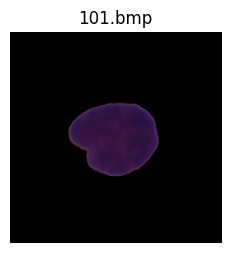

In [323]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("101.bmp")
plt.axis("off")
#get info about corresponding values 


# plt.subplot(1,2,2)
# plt.imshow(cmap="gray")
# plt.title("Mask (.npy)")
# plt.axis("off")
plt.show()

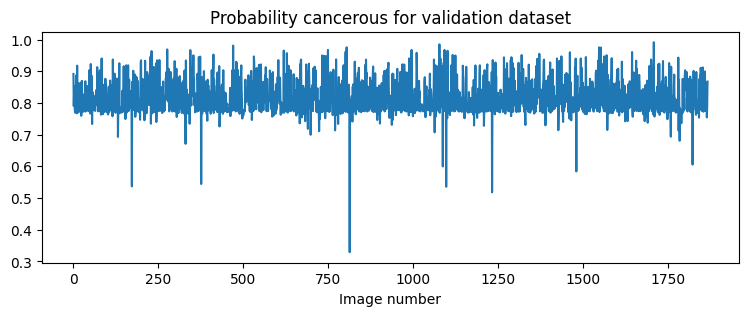

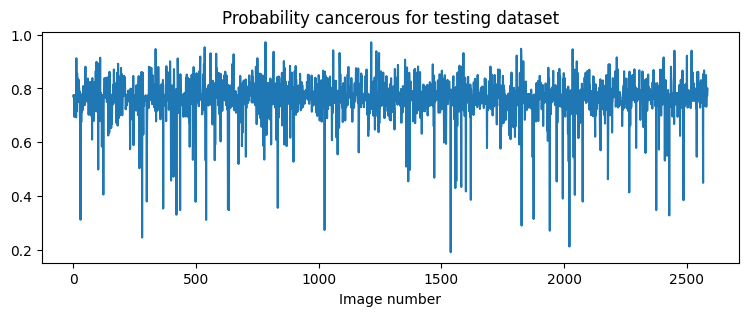

In [324]:
# Confidence in being cancer versus actually being cancer

#plt.plot(eval_df['probability_all'], eval_df['ground_truth'], 'bs')
#plotting validation dataset
plt.figure(figsize=(9,3))
plt.plot(eval_df['probability_all'])
plt.title("Probability cancerous for validation dataset")
plt.xlabel('Image number')
plt.show()

#plotting testing dataset
plt.figure(figsize=(9,3))
plt.plot(eval_dft['probability_all'])
plt.title("Probability cancerous for testing dataset")
plt.xlabel('Image number')
plt.show()

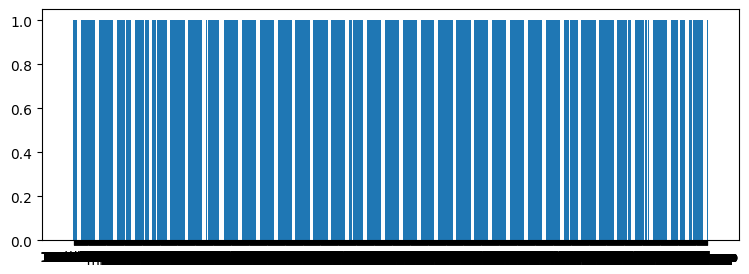

In [325]:
plt.figure(figsize=(9,3))
#plt.plot(eval_df['ground_truth'], 'bs', eval_df['pred_bin'], 'g^')
plt.bar(eval_df['basename'], eval_df['pred_bin'])
plt.show()

Since this model labeled everything as cancerous, the graphs can't actually tell us much additional information. 